In [10]:
from llama_cpp import Llama
import numpy as np
from matplotlib import pyplot as plt
import ctypes
import torch
from torch.nn import functional as F

In [11]:
model_bin = "/media/captdishwasher/Samshmung/horenbergerb/llama/llama.cpp/models/llama/converted/llama_13b_ggml_q4_3.bin"
lora_bin = "/media/captdishwasher/Samshmung/horenbergerb/llama/llama.cpp/models/SuperCOT-LoRA/13b/ggml/cutoff-2048/ggml-adapter-model.bin"

LLM = Llama(model_path=model_bin, lora_path=lora_bin, n_ctx=2048, n_threads=7, use_mmap=False, n_batch=512)

llama.cpp: loading model from /media/captdishwasher/Samshmung/horenbergerb/llama/llama.cpp/models/llama/converted/llama_13b_ggml_q4_3.bin
llama_model_load_internal: format     = ggjt v1 (latest)
llama_model_load_internal: n_vocab    = 32000
llama_model_load_internal: n_ctx      = 2048
llama_model_load_internal: n_embd     = 5120
llama_model_load_internal: n_mult     = 256
llama_model_load_internal: n_head     = 40
llama_model_load_internal: n_layer    = 40
llama_model_load_internal: n_rot      = 128
llama_model_load_internal: ftype      = 6 (mostly Q4_3)
llama_model_load_internal: n_ff       = 13824
llama_model_load_internal: n_parts    = 1
llama_model_load_internal: model size = 13B
llama_model_load_internal: ggml ctx size = 9534493.73 KB
llama_model_load_internal: mem required  = 11359.03 MB (+ 1608.00 MB per state)
....................................................................................................
llama_init_from_file: kv self size  = 1600.00 MB
llama_apply_lora_fro

In [13]:
def get_logits_and_probs(prompt):
    tokens = LLM.tokenize(prompt.encode('utf-8'))
    LLM.reset()
    LLM.eval(tokens)
    logits = LLM._logits()
    logits = np.array(logits[0])
    probs=F.softmax(torch.from_numpy(logits)).numpy()
    return logits, probs

In [22]:
def plot_logits(logits, bins=50):
    counts, bins = np.histogram(logits, bins=bins)
    plt.stairs(counts, bins)
    plt.title('Histogram of logits')

In [24]:
def plot_probs(probs, bins=1000, bins_to_skip=2):
    counts, bins = np.histogram(probs, bins=bins)
    # Observing that the vast majority of tokens are in the first bin, i.e. have incredibly small probability.
    print('There are {} tokens outside the {} smallest bins.'.format(len(np.where(probs>bins[bins_to_skip])[0]), bins_to_skip))
    # Don't plot the smallest bins since they are not interesting and dwarf all other bins
    plt.stairs(counts[bins_to_skip:], bins[bins_to_skip:])
    plt.title('Histogram of Token Probabilities')

In [1]:
def plot_most_likely_tokens(probs, num_tokens_to_plot=10):
    ind = np.argpartition(probs, -num_tokens_to_plot)[-num_tokens_to_plot:]

    likely_tokens = []
    token_probs = []

    for token in ind:
        c_token = [(ctypes.c_int)(*[token])]
        print('Token: {}, Prob: {}'.format(LLM.detokenize(c_token), probs[token]))
        likely_tokens.append(LLM.detokenize(c_token))
        token_probs.append(probs[token])

    plt.bar(likely_tokens, token_probs)
    plt.title('Bar chart of 10 most likely tokens')

In [54]:
def greedy_response_search(prompt, depth=2, num_tokens=2):
    '''Take the {num_tokens} most likely tokens, then for each token, find the {num_tokens} most likely tokens. Repeat {depth} times'''
    responses = [prompt]
    response_probs = [1.0]
    for cur in range(0, depth):
        next_responses = []
        next_probs = []
        for ind, response in enumerate(responses):
            #print('evaluating:')
            #print(response)
            tokens = LLM.tokenize(response.encode('utf-8'))
            LLM.reset()
            LLM.eval(tokens)
            logits = LLM._logits()
            logits = np.array(logits[0])
            probs=F.softmax(torch.from_numpy(logits)).numpy()
            for next_token in np.argpartition(logits, -num_tokens)[-num_tokens:]:
                c_token = [(ctypes.c_int)(*[next_token])]
                # print('Token: {} Detokenized: {}'.format(token, LLM.detokenize(c_token)))
                #print('Found token: {}'.format(LLM.detokenize(c_token).decode("utf-8")))
                next_responses.append(response + LLM.detokenize(c_token).decode("utf-8"))
                next_probs.append(response_probs[ind]*probs[next_token])
        responses = next_responses
        response_probs = next_probs
    responses = [x[len(prompt):] for x in responses]
    return responses, response_probs

In [2]:
prompt = """### Instruction:
Randomly name a fantasy race. Be creative. Answer succinctly.

### Response:
"""
logits, probs = get_logits_and_probs(prompt)
plot_logits(logits=logits)
plt.show()
plot_probs(probs)
plt.show()
plot_most_likely_tokens(probs)
plt.show()

NameError: name 'get_logits_and_probs' is not defined

/tmp/ipykernel_1021490/998085126.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs=F.softmax(torch.from_numpy(logits)).numpy()


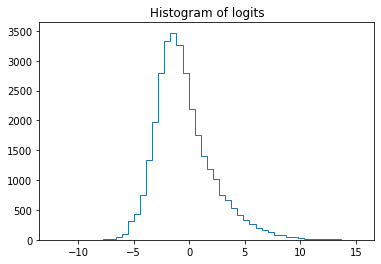

There are 167 tokens outside the 2 smallest bins.


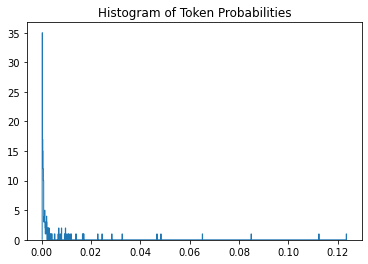

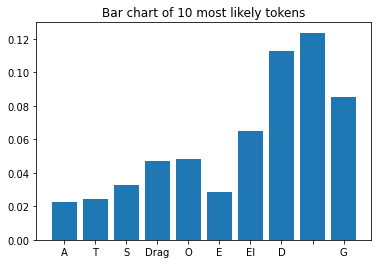

In [56]:
prompt = """### Instruction:
Randomly name a fantasy race. Be creative. Answer in one word.

### Response:
"""
logits, probs = get_logits_and_probs(prompt)
plot_logits(logits=logits)
plt.show()
plot_probs(probs)
plt.show()
plot_most_likely_tokens(probs)
plt.show()

In [58]:
responses, response_probs = greedy_response_search(prompt, depth=2, num_tokens=3)
print("Responses")
for ind, response in enumerate(responses):
    print("Probability: {}".format(response_probs[ind]))
    print(response)

/tmp/ipykernel_1021490/2290354141.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs=F.softmax(torch.from_numpy(logits)).numpy()


Responses
Probability: 0.011783598370544953
Gnom
Probability: 0.01425448403399695
Gnome
Probability: 0.033013961080903424
Gob
Probability: 0.0011144846294314607
Dem
Probability: 0.0024760043095810075
Dry
Probability: 0.09315954141257773
Dwar
Probability: 0.003968168240438095

#
Probability: 0.0826780617549568

##
Probability: 0.01963057070306834

```


/tmp/ipykernel_1021490/998085126.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs=F.softmax(torch.from_numpy(logits)).numpy()


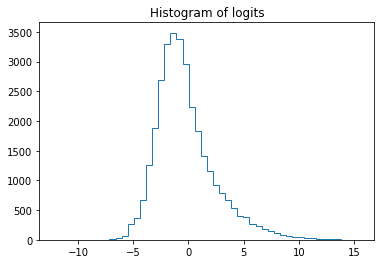

There are 206 tokens outside the 2 smallest bins.


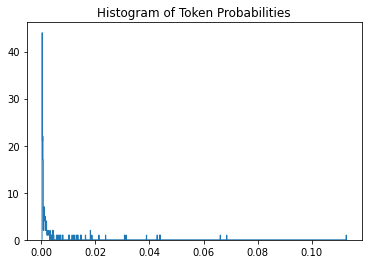

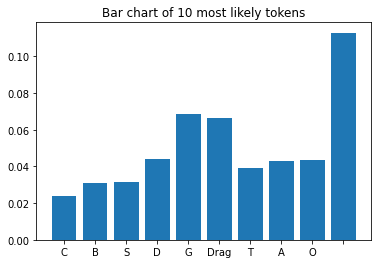

In [36]:
prompt = """### Instruction:
State a creature in a Dungeons and Dragons campaign. Be creative. Answer in one word.

### Response:\n"""
logits, probs = get_logits_and_probs(prompt)
plot_logits(logits=logits)
plt.show()
plot_probs(probs)
plt.show()
plot_most_likely_tokens(probs)
plt.show()